# Ec 143 - Problem Set 1
# Duration analysis and criminal recidivism
Due by 5PM on February 9th. The GSI, Nadav Tadelis (ntadelis@berkeley.edu), will handle the logistics of problem set collection.    

Working with your classmates on the problem set is actively encouraged, but everyone needs to turn in their own Jupyter Notebook and any other accompanying materials.    

This problem set reviews the material on discrete hazard analysis developed in lecture.

In [3]:
# Load libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
data = '/Users/shylaatchison/Ec143_Spring2023/Datasets/'
graphics = '/Users/shylaatchison/Ec143_Spring2023/Problem_Sets/'

## Load and organize dataset

This problem set uses deidentified data from the State of Iowa to study post-release recidivism among formally incarcerated individuals. The dataset includes information on 5,192 individuals who were released from prison in the 2019 fiscal year. These data are publicly available online [here](https://data.iowa.gov/Correctional-System/Iowa-Prison-Recidivism-Status-Current-Cohort/msmx-x2q6) (downloaded on 18 Jan 2023). Information about the dataset, including variable definitions, can be found on the webpage linked to above. An overview of recidivism patterns nationwide, undertaken by the U.S. Department of Justice, Bureau of Justice Statistics, can be found online [here](https://bjs.ojp.gov/BJS_PUB/rpr24s0810yfup0818/Web%20content/508%20compliant%20PDFs).

The next block of code loads the raw data into a pandas dataframe and prints out the first five records.

In [5]:
iowa = pd.read_csv (data + 'Iowa_Prison_Recidivism_Status__Current_Cohort.csv')
iowa[0:5]

,Race,Sex,Age,Supervising Unit,Supervision Type,Cohort Fiscal Year,Report Fiscal Year,Supervision Start Date,Supervision End Date,Months Supervised,...,Supervision Offense Subtype,Reincarcerated,Reincarcerated Reason,Survival Time (Days),Survival Time (Months),Reincarcerated Offense Code,Reincarcerated Offense Class,Reincarcerated Offense Type,Reincarcerated Offense Subtype,Risk Ranking
0,White,Male,39,Newton Correctional Facility,Prison,2019,2022,05/19/2014,07/08/2018,49,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,White,Male,59,Districts/Compact Regions,Work Release,2019,2022,03/22/2018,07/19/2018,3,...,Trafficking,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
2,White,Female,40,Districts/Compact Regions,Work Release,2019,2022,10/12/2018,11/20/2018,1,...,Sex,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
3,White,Male,53,Iowa Medical & Classification Center,Prison,2019,2022,09/08/2017,10/18/2018,13,...,Assault,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low
4,White,Male,53,Fort Dodge Correctional Facility,Prison,2019,2022,10/04/2018,05/08/2019,7,...,Drug Possession,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moderate


The variable **Supervision End Reason** records the reason for the individual's release from prison. We will focus on the subset of individuals who were either discharged at the end of their sentences, paroled, or paroled with immediate discharge. We will further limit ourselves to biologically male individuals. These criteria result in an estimation sample which includes 3,939 individuals who were released from prison in fiscal year 2019 (i.e., between July 1st, 2018 and June 30th 2019)

The outcome/duration of interest is the number of months until re-incarceration. Individuals are followed for up to three years post-release. If they are not re-incarcerated after three years, then the **Survival Time (Months)** variable is censored and coded as missing. We will also extract the variable **Risk Ranking**. This variable, determined prior to release, codes individuals as having a 'Low', 'Moderate' or 'High' risk of re-offending.

In [6]:
sample = iowa[['Survival Time (Months)','Risk Ranking']].loc[iowa['Supervision End Reason'].isin(['Discharged - Expiration of Sentence', 'Parole Granted', 'Paroled w/Immediate Discharge']) & (iowa['Sex'] == 'Male')]
sample.describe()

,Survival Time (Months)
count,1542.000000
mean,13.426200
std,9.176405
min,0.100000
25%,6.200000
50%,11.050000
75%,18.575000
max,36.500000


Next we create an indicator (**D**) for whether the observed spell is complete (**D = 1**) or censored (**D = 0**). We also create an observed duration (**Z**) variable. Both these variables are as described in class. We also round up the recorded duration time to the nearest integer. Hence an individual who is re-incarcerated after 0.4 months is assigned a **Z** value of 1, indicating that they were re-incarcerated in their first month post-release. In this dataset all censoring is due to the end of follow-up after 36 months, evidently no individuals are lost to follow-up prior to this time (this is so called fixed right censoring). This means that the observed duration for any censored individual is set equal to 37 months. All we know about these individuals is that they were re-incarcerated no sooner than 37 months post release.

In [7]:
sample['D'] = sample[['Survival Time (Months)']].notnull()
sample['Z'] = sample[['Survival Time (Months)']].apply(np.ceil)
sample['Z'].fillna(37, inplace = True)
sample['Z'] = sample['Z'].astype(int)
sample[['Z','D']].describe()

,Z
count,3939.000000
mean,27.943894
std,12.668515
min,1.000000
25%,15.000000
50%,37.000000
75%,37.000000
max,37.000000


## Kaplan-Meier survival function estimation

This next block of code takes the raw data and constructs a `life table' as described in class.

In [8]:
# group data by the observed duration variable, Z, in ascending order
grp = sample.groupby('Z')

# define lifetable to be a dataframe consisting of columns for
    # the number of individuals at risk corresponding to Z
    # the number of individuals re-incarcerarated corresponding to Z
    # the sum of values generated from the censor dummy indicator 
lifetable = pd.DataFrame({"N_z": grp.size(), "Re-incarcerated": grp["D"].sum()})

# Define N to be the length of the sample aka the number of rows in the df
N = len(sample)

# Define the prior count to be the cumulative summarization for the duration for all N rows
# Set index to begin at N=1 using the shift function (rather than the default N=0)
prior_count = lifetable["N_z"].cumsum().shift(1, fill_value=0)

# Insert a new column at index = 0 and define it as "At risk" and set its values = N minus the prior count
lifetable.insert(0, "At risk", N - prior_count)

# Define valuess of "Censored" = "At risk" for index = {i} minus "At risk" for index = {i-1} minus the number of re-incarcerated individuals for each row of Z
lifetable["Censored"] = (lifetable["At risk"] - lifetable["At risk"].shift(-1, fill_value=0) - lifetable["Re-incarcerated"])

# Drop the index column from the df while preserving the order of the rows of data
lifetable.drop(['N_z'], axis=1, inplace = True)

# print df
lifetable

,At risk,Re-incarcerated,Censored
Z,,,
1,3939,17,0
2,3922,36,0
3,3886,61,0
4,3825,85,0
5,3740,74,0
6,3666,102,0
7,3564,72,0
8,3492,102,0
9,3390,84,0


### Constructing A Life Table From Observations

**Q.1.** *Carefully describe how to construct a life table from observations $(Z_1, D_1), (Z_2, D_2), \dots (Z_N, D_N)$. Please place your answer within this markdown box. Also add comments to code block immediately above, indicating how this code constructs the life table.*


To construct a life table from observations $(Z_1, D_1), (Z_2, D_2), \dots (Z_N, D_N)$, we construct a column of durations from an ordered list of months from 1 to 37 that serves as an index for organizing the data for the number of individiuals at risk of re-incarceration and for the number of individuals who are re-incarcerated during each month Z, and the data for the indicator function that yields the cumulative number of individuals who survive beyond 3 years (or 36 months) in the sense that they are not re-incarcerated during the first 3 years. That is, we define

*Column 1*: [Z] the number of months since an individual was released from prison to be $Z = \{1, 2, \dots, 37\}$;

*Column 2*: [At risk] the number of individuals at risk of being re-incarcerated in month $Z$ to be $N_Z = \left( N_{Z-1} - X_{Z-1}\right)$;

*Column 3*: [Re-incarcerated] the number of individiuals who are re-incarcerated in month $Z$ to be $X_Z$;

*Column 4*: [Censored] the number of individuals who survive beyond 3 years (that is, $Z>36$) without being re-incarcerated to be $\sum_{Z=1}^{37}D_Z= \left( N_1 - \sum_{Z=1}^{36} X_Z\right)$.


### Constructing Estimates of the Hazard Rate for Durations & the Kaplan-Meier Estimate of the Survival Function

Next we construct estimates of the hazard of re-incarceration at each month post-release as well as the Kaplan-Meier estimate of the survival function.

In [32]:
# Estimates the hazard rate of re-incarceration for each duration
# The number of individiuals re-incarcerated divided by the number of individuals at risk of re-incarceration
lifetable['$\lambda(y)$'] = lifetable["Re-incarcerated"] / lifetable["At risk"]

# The Kaplan-Meier estimate of the survival function
# 1 minus the cumulative product of hazard rates
lifetable['$S(y)$'] = (1-lifetable['$\lambda(y)$']).cumprod()

# Resets index to default, beginning with 0, while preserving the order of rows
lifetable.reset_index(inplace=True)

**Q.2.** *Carefully describe how to estimate the hazard rate, $\lambda(y)$, and survival function, $S(y)$, using the information presented in the life table. Discuss how the block of code immediately above accomplishes the required calculations.*


To estimate the hazard rate $\lambda(y)$, divide the number of individiuals re-incarcerated in month $Z$ by the number of individuals at risk of being re-incarcerated in month $Z$.

To estimate the survival function $S(y)$, subtract the sum of hazard rates for month $Z_i=1, \dots, Z_N$ from 1, where $i=\{1, \dots, 36\}$ is the index in the left-most column and $i=N-1$ to determine the cumulative survival rate for each month $Z$.

For each row in the dataframe (representative of each month since an individual's release from prison), the hazard rate $\lambda(y)$ is defined to equal the number of individuals that are "Re-incarcerated" after $Z$ months divided by the number of individuals "At risk" of re-incarceration after $Z$ months.

For each row in the dataframe (representative of each month since an individual's release from prison), the survival function $S(y)$ is defined to equal the cumulative product of 
(1 - the hazard function $\lambda(y)$).

Lastly, the index is reset to the default (such that the first row is indexed with 0) while preserving the order of the rows.

In [10]:
lifetable

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$
0,1,3939,17,0,0.004316,0.995684
1,2,3922,36,0,0.009179,0.986545
2,3,3886,61,0,0.015697,0.971059
3,4,3825,85,0,0.022222,0.949480
4,5,3740,74,0,0.019786,0.930693
5,6,3666,102,0,0.027823,0.904798
6,7,3564,72,0,0.020202,0.886519
7,8,3492,102,0,0.029210,0.860625
8,9,3390,84,0,0.024779,0.839299
9,10,3306,75,0,0.022686,0.820259


## Computing Percentiles of the Distribution of Durations

**Q.3.** *What is the 0.25 quantile of the distribution of durations until re-incarceration. What is the median duration? Explain. Please place your answer in this markdown box.*


The 0.25 quantile, or 25th percentile, of the distribution of durations until re-incarceration is after $Z=15$ months, since $1 -S(Z=15)= 1 - (0.743590) = 0.256410$. So, 25% of individuals are re-incarcerrated after $Z=15$ months.

The median, or 50th percentile, of the distribution of durations is after $Z=37$ months because $1-S(Z=37)=1- (0.608530) =0.39147$. Therefore, we know the median duration of re-incarceration must be well beyond the 3 years for which re-incarceration is tracked.

### Python Code for Generating a Plot for the Estimated Survival Curve and a Plot for the Hazard Function

The next block of code generates plots of the estimated survival curve and hazard function.

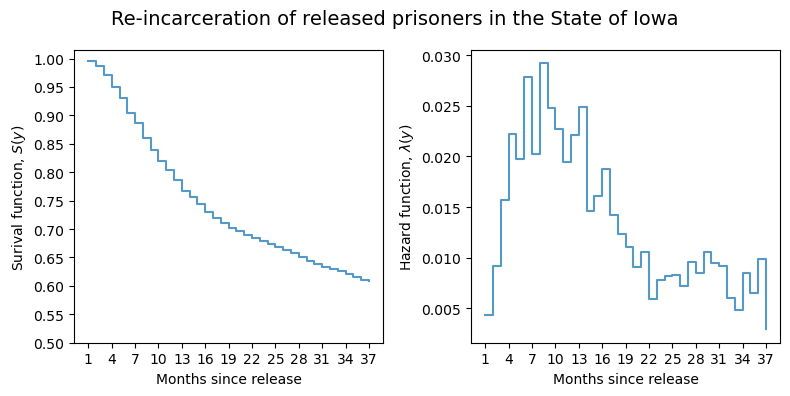

In [43]:
# Define figure object with two subplots
fig_survival, sbp = plt.subplots(ncols=2, figsize=(8, 4))
ax0 = sbp[0] # Handle for left subplot
ax1 = sbp[1] # Handle for right subplot
fig_survival.suptitle('Re-incarceration of released prisoners in the State of Iowa', fontsize=14)

color = '#3B7EA1'                                                                        # Founder's Rock

# Survival function
ax0.set_xlabel(r'Months since release')
ax0.set_ylabel(r'Surival function, $S(y)$')
s = ax0.step(lifetable['Z'], lifetable['$S(y)$'], alpha = 0.75, where = 'post')

ax0.tick_params(axis='y')
ax0.set_xticks([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])
ax0.set_yticks([1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50])
ax0.set_yticklabels(['1.00', '0.95', '0.90', '0.85', '0.80', '0.75', '0.70', '0.65', '0.60', '0.55', '0.50'])

# Hazard function
ax1.set_xlabel(r'Months since release')
ax1.set_ylabel(r'Hazard function, $\lambda(y)$')
s = ax1.step(lifetable['Z'], lifetable['$\lambda(y)$'], alpha = 0.75, where = 'post')

ax1.tick_params(axis='y')
ax1.set_xticks([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])



fig_survival.tight_layout()  
plt.savefig(graphics + 'fig_survival', bbox_inches='tight', dpi=500) 

## Interpretating the Estimated Survival Curve and Hazard Function

**Q.4.** *Provide a narrative description of both graphs above. At what point is the hazard of re-incarceration greatest? Describe the shape of the hazard function. Discuss possible implications for prisoner re-entry policy. Please place your answer in this markdown box.*


**Interpretation:** 
The left graph depicts the survival function, indicating the percentage of individuals who avoid being re-incarcerated, over time in months since the release of prisoners in Iowa and the right graph depicts the harzard function, indicating the risk of re-incarceration, over time in months since the release of prisoners in Iowa. Displaying the two graphs side-by-side horizontally, where both graphs have identical (horizontal) x-axes, allows us to compare variation between the two graphs vertically along the y-axes (that is, variation between the survival function and the hazard function) over time. Thus, the two graphs depict how the relationship between the number of individuals who avoid re-incarceration and the number of individuals at risk of re-incarceration compare over. time. The graphs indicate that 9 months after release from prison, both the number of individuals who avoid re-incarceration and the number of individuals at risk of re-incarceration trend downwards with a more drastic slope (i.e., while the first derivative is negative, the second derivative increases after 9 months such that the slopes of the functions become increasingly negative over time).


**Maximum of the Hazard Function:** 
The hazard of re-incarceration is greatest during the 9th month after release.


**Hazard Function Shape:** 
The shape of the hazard function is decreasing, meaning the chance of re-incarceration is much higher during the earlier months after release and decreases over time.

**Implications:** 
Implications for prisoner re-entry policy may include the tendency for individuals who have been released from prison for a longer period of time to have a lower chance of re-incarceration than the chance of re-incarceration for individuals who have been released from prison more recently.

## Constructing a Pointwise 95% Confidence Interval for the Kaplan-Meier Estimation of the Survivial Function

**Q.5.** *Construct a pointwise 95 percent confidence interval for the Kaplan-Meier estimation of the survival function (as discussed in lecture). Add the confidence interval to the survival function plot above.*

### Definitions

The **Kaplan-Meier estimation of the survival function** is given by

$\hat{S}(Y_{(k)})= \prod_{i=1}^k \left(1 - \hat{\lambda}(Y_{(k)}) \right) = \prod_{i=1}^k \frac{N_{(k)}- N_{(k)}^d}{N_{(k)}} \Longrightarrow \hat{S}(y)= \prod_{i=1}^{36} \frac{(\text{"At Risk"})_i - (\text{"Re-incarcerated"})_i}{(\text{"At Risk"})_i}$

The **standard error** for the Kaplan-Meier estimation is given by

$\text{S_E} = \hat{S}(y) \cdot \sqrt{\sum_{i=1}^k \frac{(\text{"Re-incarcerated"})_i}{(\text{"At risk"})_i \cdot \left[(\text{"At risk"})_i - (\text{"Re-incarcerated"})_i \right]}}$

The **pointwise 95% confidence interval** for $y_i$ is given by

$\left[\hat{S}(y_i) - 1.96S_E \cdot \hat{S}(y_i), \text{ } \hat{S}(y_i) + 1.96 S_E \cdot \hat{S}(y_i) \right]$

### Python Code for Manipulating the Dataframe of the Life Table to Construct a Pointwise 95% Confidence Interval

In [73]:
# Computing the inner fraction within the standard error
lifetable["se_inner_frac"] = lifetable["Re-incarcerated"] / (lifetable["At risk"] * (lifetable["At risk"] - lifetable["Re-incarcerated"]))

# Computing the standard error
lifetable["Standard Error"] = (lifetable["se_inner_frac"].cumsum())**0.5

# Computing the pointwise 95 percent confidence interval lower bound
lifetable["CI Lower Bound"] = lifetable['$S(y)$'] - 1.96 * lifetable["Standard Error"] * lifetable['$S(y)$']

# Computing the pointwise 95 percent confidence interval upper bound
lifetable["CI Upper Bound"] = lifetable['$S(y)$'] + 1.96 * lifetable["Standard Error"] * lifetable['$S(y)$']

lifetable

,Z,At risk,Re-incarcerated,Censored,$\lambda(y)$,$S(y)$,CI Lower Bound,CI Upper Bound,se_inner_frac,Standard Error
0,1,3939,17,0,0.004316,0.995684,0.993637,0.997731,0.000001,0.001049
1,2,3922,36,0,0.009179,0.986545,0.982947,0.990143,0.000002,0.001861
2,3,3886,61,0,0.015697,0.971059,0.965823,0.976294,0.000004,0.002751
3,4,3825,85,0,0.022222,0.949480,0.942640,0.956319,0.000006,0.003675
4,5,3740,74,0,0.019786,0.930693,0.922762,0.938625,0.000005,0.004348
5,6,3666,102,0,0.027823,0.904798,0.895633,0.913964,0.000008,0.005168
6,7,3564,72,0,0.020202,0.886519,0.876614,0.896425,0.000006,0.005701
7,8,3492,102,0,0.029210,0.860625,0.849809,0.871440,0.000009,0.006412
8,9,3390,84,0,0.024779,0.839299,0.827830,0.850768,0.000007,0.006972
9,10,3306,75,0,0.022686,0.820259,0.808268,0.832250,0.000007,0.007459


### Python Code for Including the 95% Confidence Interval in the Survival Function Plot

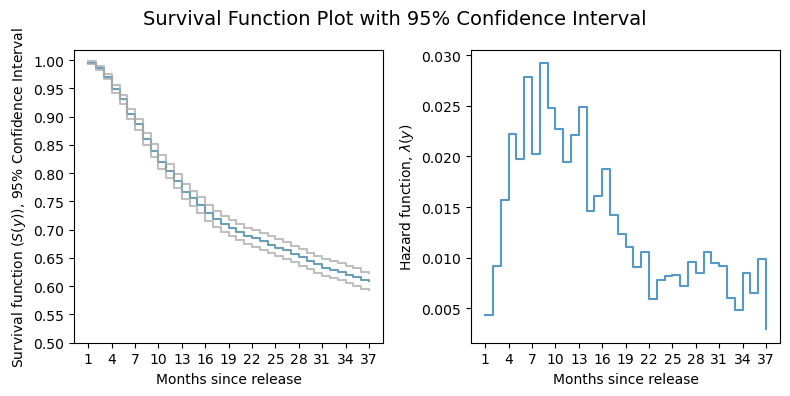

In [76]:
# Define figure object with two subplots
fig_survival_ci, sbp = plt.subplots(ncols=2, figsize=(8, 4))
ax0 = sbp[0] # Handle for left subplot
ax1 = sbp[1] # Handle for right subplot
fig_survival_ci.suptitle('Survival Function Plot with 95% Confidence Interval', fontsize=14)                                                                       # Founder's Rock

# Survival function with 95% confidence interval
ax0.set_xlabel(r'Months since release')
ax0.set_ylabel(r'Survival function $\left(S(y)\right)$, 95% Confidence Interval')
# Plotting the previously-defined survival function plot
s = ax0.step(lifetable['Z'], lifetable['$S(y)$'], color = '#3B7EA1', alpha = 0.75, where = 'post')
# Adding the confidence interval to the survival function plot
s = ax0.step(lifetable['Z'], lifetable['CI Lower Bound'], color='#AAAAAA', alpha = 0.75, where = 'post')
s = ax0.step(lifetable['Z'], lifetable['CI Upper Bound'], color='#AAAAAA', alpha = 0.75, where = 'post')



ax0.tick_params(axis='y')
ax0.set_xticks([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])
ax0.set_yticks([1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50])
ax0.set_yticklabels(['1.00', '0.95', '0.90', '0.85', '0.80', '0.75', '0.70', '0.65', '0.60', '0.55', '0.50'])

# Hazard function
ax1.set_xlabel(r'Months since release')
ax1.set_ylabel(r'Hazard function, $\lambda(y)$')
s = ax1.step(lifetable['Z'], lifetable['$\lambda(y)$'], alpha = 0.75, where = 'post')

ax1.tick_params(axis='y')
ax1.set_xticks([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])



fig_survival_ci.tight_layout()  
plt.savefig(graphics + 'fig_survival_ci', bbox_inches='tight', dpi=500) 

## Survivial Analysis with Risk Rankings

**Q.6.** *Repeat your analysis for the subsamples of individuals with a **Risk Ranking** of (i)'Low' or 'Moderate and (ii) 'High'. How does the risk of re-incarceration vary across these two groups? Plot the two estimated survival curves on the same graph and provide a narrative description of the graph in a markdown box below it.*

**THIS IS MESSED UP MAN**

In [88]:
sample['R'] = sample[['Risk Ranking']].notnull()
sample['R'] = sample['R'].astype(float)

# group data by the observed duration variable, Z, in ascending order
grp = sample.groupby('Z')

# define lifetable to be a dataframe consisting of columns for
    # the number of individuals at risk corresponding to Z
    # the number of individuals re-incarcerarated corresponding to Z
    # the sum of values generated from the censor dummy indicator
    # the sum of individuals who are high risk
    # the sum of individuals who are not high risk
lifetable_riskranking = pd.DataFrame({"N_z": grp.size(), "Re-incarcerated": grp["D"].sum()})

# Define N to be the length of the sample aka the number of rows in the df
N = len(sample)

# Define the prior count to be the cumulative summarization for the duration for all N rows
# Set index to begin at N=1 using the shift function (rather than the default N=0)
prior_count = lifetable_riskranking["N_z"].cumsum().shift(1, fill_value=0)

# Insert a new column at index = 0 and define it as "At risk" and set its values = N minus the prior count
lifetable_riskranking.insert(0, "At risk", N - prior_count)

highrisk = sample["Risk Ranking" == "High"]
lifetable_riskranking.insert(0, "High risk", highrisk.count)
lifetable_riskranking.insert(0, "Non-high risk", N - highrisk.count)



# Define valuess of "Censored" = "At risk" for index = {i} minus "At risk" for index = {i-1} minus the number of re-incarcerated individuals for each row of Z
lifetable_riskranking["Censored"] = (lifetable_riskranking["At risk"] - lifetable_riskranking["At risk"].shift(-1, fill_value=0) - lifetable_riskranking["Re-incarcerated"])

# Drop the index column from the df while preserving the order of the rows of data
lifetable_riskranking.drop(['N_z'], axis=1, inplace = True)

# print df
lifetable_riskranking

KeyError: False

# Discrete Hazard Regression Analysis

This next block of code constructs a "person-period" dataset so that we can use logistic regression methods to fit a discrete time hazard model as described in class.    

In [28]:
records = sample[['Z','D','Risk Ranking']].to_dict("records")

person_period = []

for unit in records:
    for t in range(1,(unit['Z']+1)):
        unit_t = unit.copy()
        unit_t['t'] = t
        unit_t['exit'] = (t == unit_t['Z']) and (unit_t['D'] == 1)
        person_period.append(unit_t)
        
ppdf = pd.DataFrame(person_period)
ppdf.rename(columns={'Risk Ranking': 'risk'}, inplace = True)
ppdf[0:15]

,Z,D,risk,t,exit
0,37,False,Low,1,False
1,37,False,Low,2,False
2,37,False,Low,3,False
3,37,False,Low,4,False
4,37,False,Low,5,False
5,37,False,Low,6,False
6,37,False,Low,7,False
7,37,False,Low,8,False
8,37,False,Low,9,False
9,37,False,Low,10,False


**Q.7.** *Describe how to construct the person-period dataset in words. How does the code block above accomplish this? Please write your answer in this markdown box. Add comments to the code block above.*


Create a list of dictionaries called "records", where each dictionary is a unit-period observation. Then convert the list of dictionaries into a dataframe and rename the column 'Risk Ranking' to 'risk'. Then we call the first 15 rows of the dataframe to be displayed.

Next we use statmodels to fit a discrete time hazard model to explore the effects of the risk rating on the hazard of reincarceration. We will leave the baseline hazard fully flexible.

In [89]:
# Import the statsmodels package
import statsmodels.api as sm
# Import the formula API from the statsmodels package
import statsmodels.formula.api as smf

# Fit a logistic regression model to the data
result = smf.glm(formula = "exit ~ C(t) + C(risk)", 
                 data=ppdf,
                 family=sm.families.Binomial()).fit()

# Print the results of the model
print(result.summary())

                       Generalized Linear Model Regression Results                       
Dep. Variable:     ['exit[False]', 'exit[True]']   No. Observations:               107903
Model:                                       GLM   Df Residuals:                   107864
Model Family:                           Binomial   Df Model:                           38
Link Function:                             Logit   Scale:                          1.0000
Method:                                     IRLS   Log-Likelihood:                -7833.0
Date:                           Fri, 17 Feb 2023   Deviance:                       15666.
Time:                                   07:08:58   Pearson chi2:                 1.08e+05
No. Iterations:                                9   Pseudo R-squ. (CS):           0.004205
Covariance Type:                       nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------

## Interpreting the Coefficients on Risk Ratings

**Q.8.** *Interpret the coefficients on the "low" and "moderate" risk ratings? Please write your answer in this markdown box.* 

The coefficient for the low risk rating "C(risk)[T.Low]" = 0.3006 implies a 30.06% risk associated with the hazard of re-incarceration.

The coefficient for the moderate risk rating "C(risk) [T.Moderate]" = 0.3263 implies a 32.63% risk associated with the hazard of re-incarceration.

## Modeling Baseline Hazard Restricted to LIE on Fourth Order Polynomial

**Q.9.** Fit a model where the baseline hazard is restricted to lie on fourth order polynomial. How do your results compare to those with fully flexible baseline hazard. Please write your answer in this markdown box. 


I assume LIE refers to the Law of Iterated Expectations. By restricting the baseline hazard to LIE on the fourth order polynomial, our model becomes $C(t)= 5.2962 -0.7598t -1.2868t^2 -1.6581t^3$.

## Additional Analyses

**Q.10.** What other types of analyses would you be interested in conducting. What additional types of data do you think it would be useful for the State of Iowa to collect? Please write your answer in this markdown box.


I'd want to know what caused so much uncertainty in durations 22, 26, 32, 35, and 37 such that the p-values are larger than 0.05. I'd conduct a robustness check by bootstrapping to cluster by risk ratings and cluster by whether exit is true or false for standard errors to be robust. I'd also like to try adding a control for seasonality to test whether the previously mentioned duration periods result in coefficients with statistically significant p-values. I'd additionally want to test for independence since covariance in nonrobust.